In [34]:
# Importing data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Download latest version
path = kagglehub.dataset_download("jayaantanaath/student-habits-vs-academic-performance")

# Validate
for root, dirs, files in os.walk(path):
    print(f"Root: {root}, Files: {files}")

df = pd.read_csv(path + '/student_habits_performance.csv')
print(df.info)

Root: /Users/james/.cache/kagglehub/datasets/jayaantanaath/student-habits-vs-academic-performance/versions/1, Files: ['student_habits_performance.csv']
<bound method DataFrame.info of     student_id  age  gender  study_hours_per_day  social_media_hours  \
0        S1000   23  Female                  0.0                 1.2   
1        S1001   20  Female                  6.9                 2.8   
2        S1002   21    Male                  1.4                 3.1   
3        S1003   23  Female                  1.0                 3.9   
4        S1004   19  Female                  5.0                 4.4   
..         ...  ...     ...                  ...                 ...   
995      S1995   21  Female                  2.6                 0.5   
996      S1996   17  Female                  2.9                 1.0   
997      S1997   20    Male                  3.0                 2.6   
998      S1998   24    Male                  5.4                 4.1   
999      S1999   19  Fem

internet_quality
Good       447
Average    391
Poor       162
Name: count, dtype: int64

extracurricular_participation
No     682
Yes    318
Name: count, dtype: int64

count    1000.000000
mean        5.438000
std         2.847501
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: mental_health_rating, dtype: float64


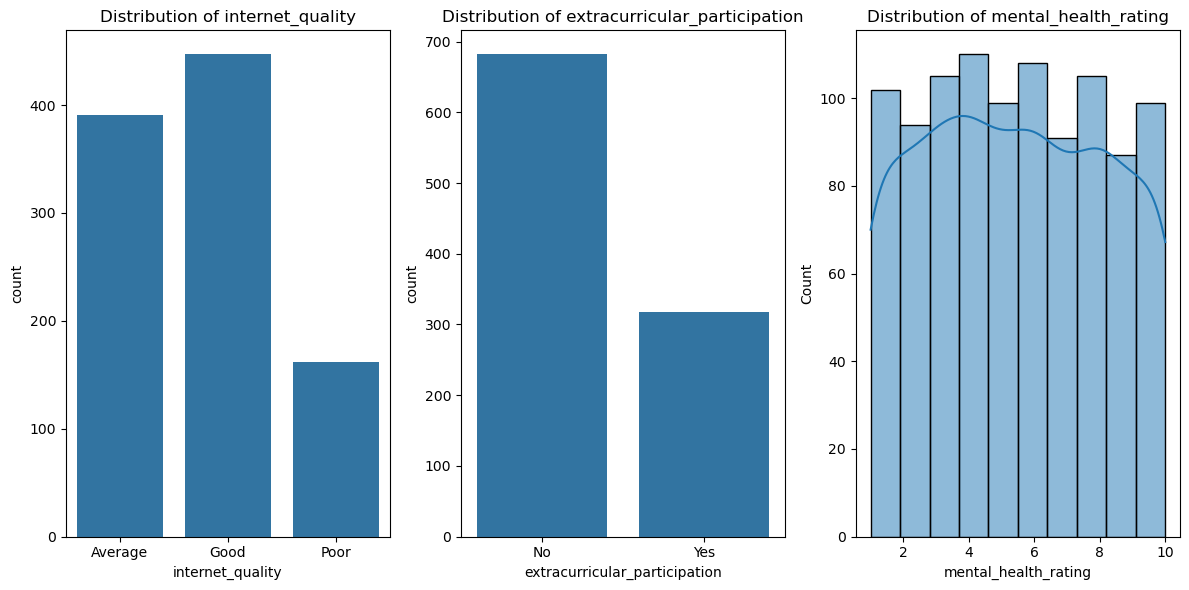

In [19]:
# Data evaluation
print(df['internet_quality'].value_counts())
print()
print(df['extracurricular_participation'].value_counts())
print()
print(df['mental_health_rating'].describe())

# Convert categorical to category type
df['internet_quality'] = df['internet_quality'].astype('category')
df['extracurricular_participation'] = df['extracurricular_participation'].astype('category')

features_to_plot = ['internet_quality', 'extracurricular_participation', 'mental_health_rating']
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(1, 3, i)
    if df[feature].dtype.name == 'category':
        sns.countplot(data=df, x=feature)
    else:
        sns.histplot(df[feature], kde=True, bins=10)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [35]:
import pandas as pd
import scipy.stats as stats
import numpy as np

# Make a copy to avoid modifying the original
df_corr = df.copy()

# Convert applicable columns
df_corr['extracurricular_participation'] = df_corr['extracurricular_participation'].map({'Yes': 1, 'No': 0})
df_corr['part_time_job'] = df_corr['part_time_job'].map({'Yes': 1, 'No': 0})
ordinal_map = {'Poor': 1, 'Fair': 2, 'Good': 3}
df_corr['diet_quality'] = df_corr['diet_quality'].map(ordinal_map)

# Container for correlation results
correlations = []

for col in df_corr.columns:
    if col in ['student_id', 'exam_score']:
        continue

    feature_type = ''
    corr = np.nan
    p = np.nan
    F_stat = np.nan

    if pd.api.types.is_numeric_dtype(df_corr[col]):
        # Pearson correlation
        corr, p = stats.pearsonr(df_corr[col], df_corr['exam_score'])
        feature_type = 'numeric'

    elif df_corr[col].nunique() == 2:
        # Binary categorical -> Point-Biserial
        corr, p = stats.pointbiserialr(df_corr[col], df_corr['exam_score'])
        feature_type = 'binary categorical'

    elif df_corr[col].nunique() > 2:
        # Categorical -> One-way ANOVA
        groups = [df_corr[df_corr[col] == level]['exam_score'] for level in df_corr[col].unique()]
        F_stat, p = stats.f_oneway(*groups)
        feature_type = 'categorical (ANOVA)'

    correlations.append({
        'feature': col,
        'type': feature_type,
        'correlation': corr,
        'p_value': p,
        'F_statistic': F_stat
    })

# Convert to DataFrame
correlation_df = pd.DataFrame(correlations).sort_values(by='correlation', key=lambda x: x.abs(), ascending=False)
print(correlation_df)


                          feature                 type  correlation  \
2             study_hours_per_day              numeric     0.825419   
12           mental_health_rating              numeric     0.321523   
4                   netflix_hours              numeric    -0.171779   
3              social_media_hours              numeric    -0.166733   
9              exercise_frequency              numeric     0.160107   
7                     sleep_hours              numeric     0.121683   
6           attendance_percentage              numeric     0.089836   
5                   part_time_job              numeric    -0.026608   
8                    diet_quality              numeric     0.015018   
0                             age              numeric    -0.008907   
13  extracurricular_participation              numeric     0.000881   
1                          gender  categorical (ANOVA)          NaN   
10       parental_education_level  categorical (ANOVA)          NaN   
11    

/var/folders/yz/kh_g97657d54l0hxc01q2jpw0000gn/T/ipykernel_23339/2119295665.py:39: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  F_stat, p = stats.f_oneway(*groups)


In [28]:
print("Mean:\n", df[features_to_plot].select_dtypes(include=np.number).mean())
print("\nMedian:\n", df[features_to_plot].select_dtypes(include=np.number).median())
print("\nStandard Deviation:\n", df[features_to_plot].select_dtypes(include=np.number).std())

Mean:
 mental_health_rating    5.438
dtype: float64

Median:
 mental_health_rating    5.0
dtype: float64

Standard Deviation:
 mental_health_rating    2.847501
dtype: float64


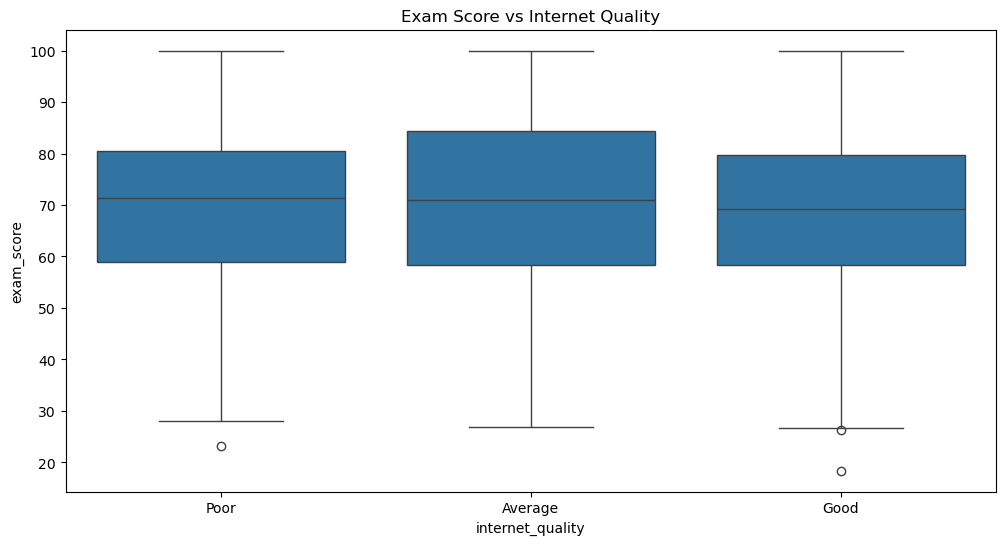

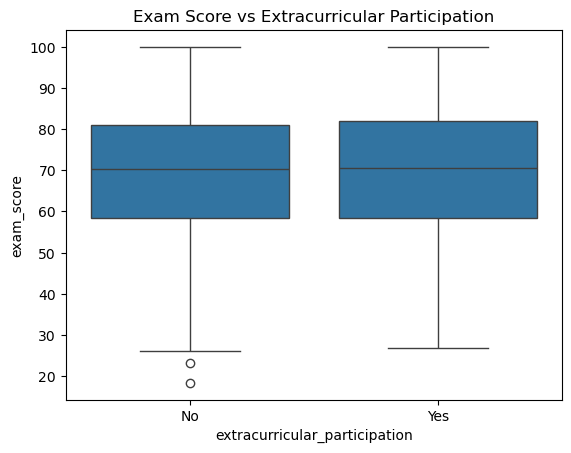

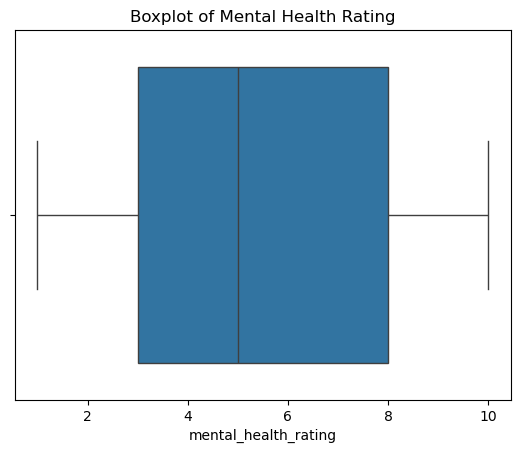

Empty DataFrame
Columns: [student_id, mental_health_rating, exam_score]
Index: []


In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='internet_quality', y='exam_score', order=['Poor', 'Average', 'Good'])
plt.title('Exam Score vs Internet Quality')
plt.show()

sns.boxplot(data=df, x='extracurricular_participation', y='exam_score')
plt.title('Exam Score vs Extracurricular Participation')
plt.show()

sns.boxplot(data=df, x='mental_health_rating')
plt.title('Boxplot of Mental Health Rating')
plt.show()

Q1 = df['mental_health_rating'].quantile(0.25)
Q3 = df['mental_health_rating'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['mental_health_rating'] < Q1 - 1.5 * IQR) | (df['mental_health_rating'] > Q3 + 1.5 * IQR)]
print(outliers[['student_id', 'mental_health_rating', 'exam_score']].head())

In [23]:
print("Correlation Matrix:")
print(df[['mental_health_rating', 'exam_score']].corr())

print("\n Covariance Matrix:")
print(df[['mental_health_rating', 'exam_score']].cov())

Correlation Matrix:
                      mental_health_rating  exam_score
mental_health_rating              1.000000    0.321523
exam_score                        0.321523    1.000000

 Covariance Matrix:
                      mental_health_rating  exam_score
mental_health_rating              8.108264   15.462105
exam_score                       15.462105  285.223591
